In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *

In [2]:
ds_climatology = load_climatology_with_deptho().isel(depth=0)
ds_surface = load_surface_data()

In [3]:
ds_anomalies = ds_surface.groupby('time.month') - ds_climatology
ds_anomalies

<xarray.Dataset>
Dimensions:    (time: 252, latitude: 121, longitude: 1440)
Coordinates:
    depth      (time) float32 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    S          (time, latitude, longitude) float32 0.2056 0.2059 ... -0.4106
    T          (time, latitude, longitude) float32 0.4319 0.4676 ... 0.03259
    SIC        (time, latitude, longitude) float32 -0.0006149 ... 0.001133
    SIT        (time, latitude, longitude) float32 -0.002763 ... -0.01426
    U          (time, latitude, longitude) float32 -0.02665 ... -0.0005737
    V          (time, latitude, longitude) float32 0.03762 ... -0.0001231
    SSH        (time, latitude, longitude) float32 -0.02152 -0.01225 ... 0.1164

## Global trend

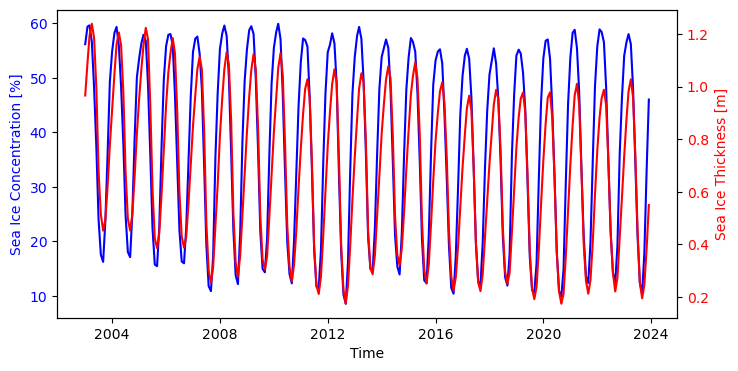

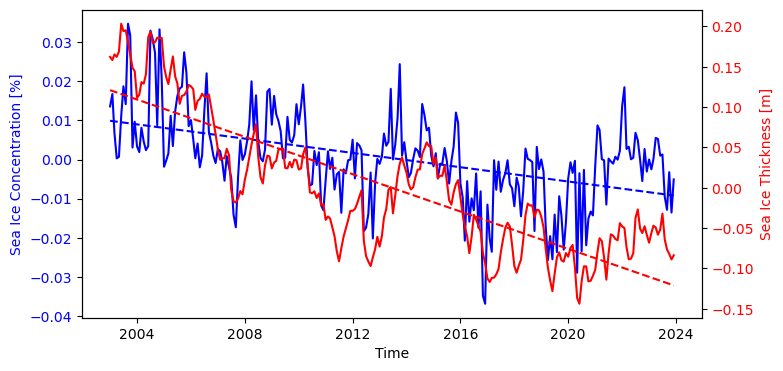

In [4]:
weight = np.cos(np.deg2rad(ds_anomalies.latitude))
weight /= weight.sum()

mean_SIC = 100 * (ds_surface['SIC'].mean('longitude') * weight).sum('latitude')
mean_SIT = (ds_surface['SIT'].mean('longitude') * weight).sum('latitude')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
axL, axR = ax, ax.twinx()
axL.plot(mean_SIC.time, mean_SIC, color='b', label='Mean SIC')
axR.plot(mean_SIT.time, mean_SIT, color='r', label='Mean SIT')

ax.set_xlabel('Time')
axL.set_ylabel('Sea Ice Concentration [%]', color='b')
axL.tick_params(axis='y', labelcolor='b')
axR.tick_params(axis='y', labelcolor='r')
axR.set_ylabel('Sea Ice Thickness [m]', color='r')
#plt.title('Mean SIC and SIT evolution')
plt.savefig('figs/sea_ice_variability/mean_SIC_SIT_evolution.png', bbox_inches='tight')
plt.show()

mean_SIC = 100 % (ds_anomalies['SIC'].mean('longitude') * weight).sum('latitude') 
mean_SIT = (ds_anomalies['SIT'].mean('longitude') * weight).sum('latitude')

SIC_linear_coefs = np.polyfit(mean_SIC.time.astype('int64'), mean_SIC, 1)
SIT_linear_coefs = np.polyfit(mean_SIT.time.astype('int64'), mean_SIT, 1)

SIC_linear_trend = np.polyval(SIC_linear_coefs, mean_SIC.time.astype('int64'))
SIT_linear_trend = np.polyval(SIT_linear_coefs, mean_SIT.time.astype('int64'))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
axL, axR = ax, ax.twinx()
axL.plot(mean_SIC.time, mean_SIC, color='b', label='Mean SIC')
axR.plot(mean_SIT.time, mean_SIT, color='r', label='Mean SIT')
axL.plot(mean_SIC.time, SIC_linear_trend, color='b', linestyle='--', label='SIC linear trend')
axR.plot(mean_SIC.time, SIT_linear_trend, color='r', linestyle='--', label='SIT linear trend')

ax.set_xlabel('Time')
axL.set_ylabel('Sea Ice Concentration [%]', color='b')
axL.tick_params(axis='y', labelcolor='b')
axR.tick_params(axis='y', labelcolor='r')
axR.set_ylabel('Sea Ice Thickness [m]', color='r')
plt.savefig('figs/sea_ice_variability/mean_SIC_SIT_anomalies_evolution.png', bbox_inches='tight')
#plt.title('Mean SIC and SIT anomalies evolution')
plt.show()



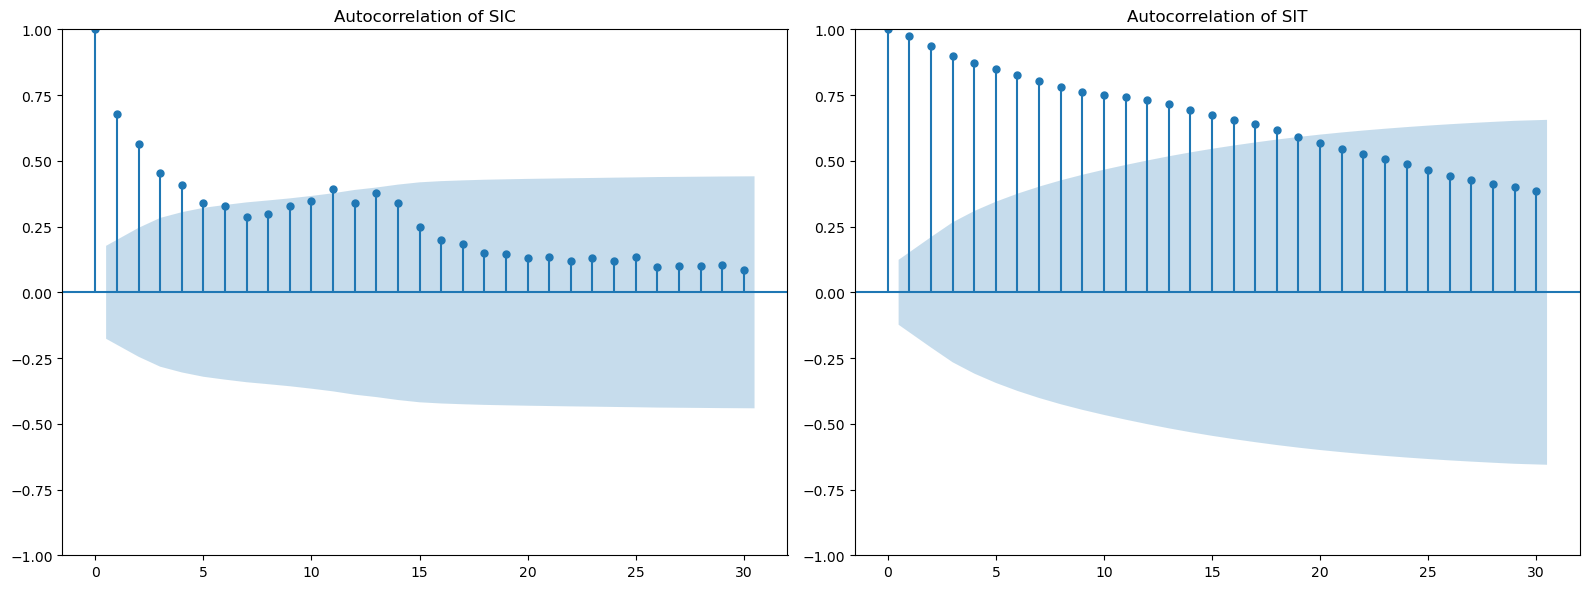

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot autocorrelation for SIC
plot_acf(mean_SIC, ax=axs[0], lags=30, alpha=0.005)
axs[0].set_title('Autocorrelation of SIC')

# Plot autocorrelation for SIT
plot_acf(mean_SIT, ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('Autocorrelation of SIT')

plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import scipy.stats as stats

# Régression linéaire
time_in_seconds = mean_SIC.time.astype('int64') / 1e9
slope, intercept, r_value, p_value, std_err = stats.linregress(time_in_seconds, mean_SIT)

# Affichage des résultats
print(f"Pente estimée (β1): {slope}")
print(f"Erreur standard de la pente: {std_err}")
print(f"Statistique t: {slope / std_err}")
print(f"P-valeur: {p_value}")

# Interprétation
alpha = 0.05
if p_value < alpha:
    print("La tendance linéaire est significative (on rejette H0).")
else:
    print("La tendance linéaire n'est pas significative (on ne rejette pas H0).")

Pente estimée (β1): -3.665023934424232e-10
Erreur standard de la pente: 1.5298056867883958e-11
Statistique t: -23.95744744627284
P-valeur: 1.0828853863769865e-66
La tendance linéaire est significative (on rejette H0).


In [7]:
from scipy.stats import ttest_1samp, pearsonr


SIC_trend_corr = np.corrcoef(time_in_seconds, mean_SIC)[0, 1]
SIT_trend_corr = np.corrcoef(time_in_seconds, mean_SIT)[0, 1]

# Calcul de r et de la p-valeur
r, p_value = pearsonr(time_in_seconds, mean_SIC)

# Calcul manuel de la statistique t
n = len(time_in_seconds)
t_stat = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)

# Affichage des résultats
print(f"Coefficient de corrélation r: {r}")
print(f"Statistique t: {t_stat}")
print(f"P-valeur: {p_value}")

# Test de significativité
alpha = 0.05
if p_value < alpha:
    print("La corrélation est significative (on rejette H0, tendance linéaire présente).")
else:
    print("La corrélation n'est pas significative (on ne rejette pas H0).")

Coefficient de corrélation r: -0.48098353278150696
Statistique t: -8.674301811378811
P-valeur: 5.386124117618615e-16
La corrélation est significative (on rejette H0, tendance linéaire présente).


La banquise perd plus vite en volume qu'en surface ??

## Anomalies std

In [8]:
ds_anomalies_std = ds_anomalies.std('time')

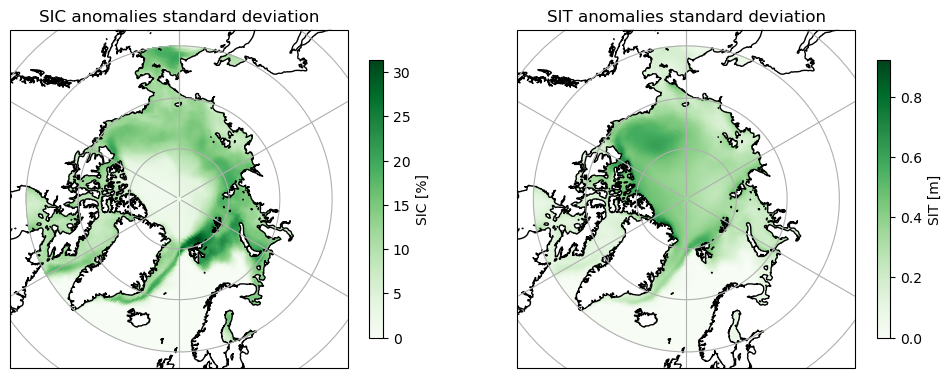

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs[0]
pcm = ax.pcolormesh(ds_anomalies_std['longitude'], ds_anomalies_std['latitude'], 100 * ds_anomalies_std['SIC'], cmap='Greens', transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='SIC [%]', shrink=0.6)
ax.set_title('SIC anomalies standard deviation')
ax.coastlines()
ax.gridlines()

ax = axs[1]
pcm = ax.pcolormesh(ds_anomalies['longitude'], ds_anomalies['latitude'], ds_anomalies_std['SIT'], cmap='Greens', transform=ccrs.PlateCarree())
plt.colorbar(pcm, ax=ax, label='SIT [m]', shrink=0.6)
ax.set_title('SIT anomalies standard deviation')
ax.coastlines()
ax.gridlines()

plt.savefig('figs/sea_ice_variability/SIC_SIT_anomalies_std_maps.png', bbox_inches='tight')
plt.show()


## Anomalies map

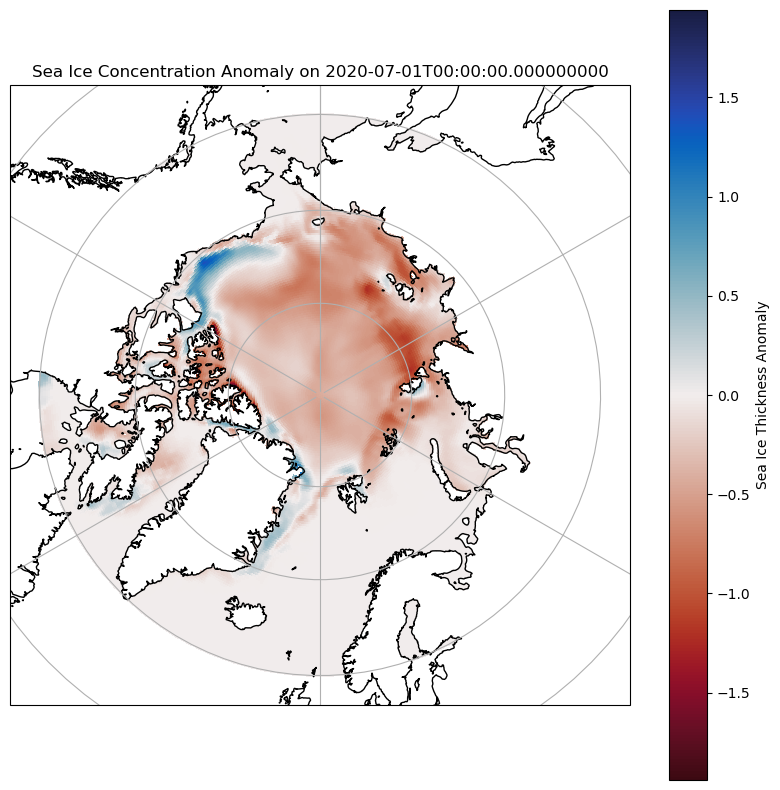

In [10]:
# random date
date = np.random.choice(ds_anomalies.time.values)

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    ds_anomalies.longitude, 
    ds_anomalies.latitude, 
    ds_anomalies.sel(time=date)['SIT'], 
    transform=ccrs.PlateCarree(), 
    cmap=cmo.balance.reversed(),
    vmin = -np.abs(ds_anomalies.sel(time=date)['SIT']).max(),
    vmax = np.abs(ds_anomalies.sel(time=date)['SIT']).max()
)
plt.colorbar(pcm, ax=ax, label='Sea Ice Thickness Anomaly')
plt.title(f'Sea Ice Concentration Anomaly on {date}')
plt.show()


## Distributions

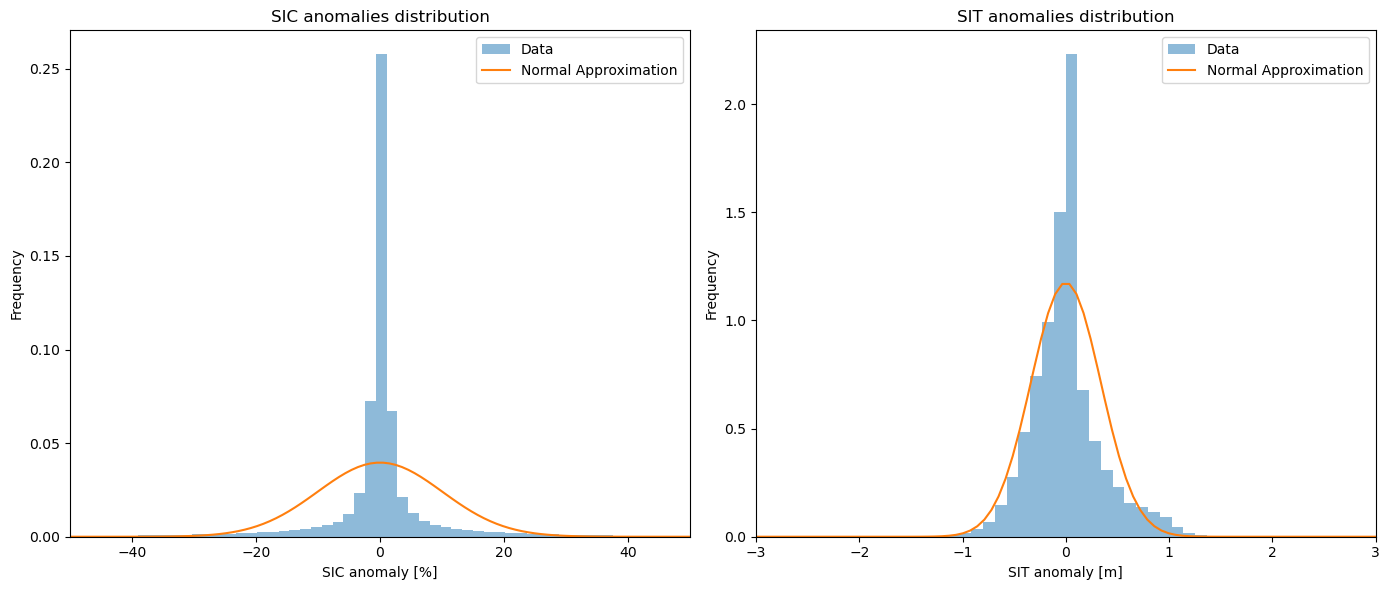

In [21]:
SIC_all_values = 100 * ds_anomalies['SIC'].values.flatten()
SIT_all_values = ds_anomalies['SIT'].values.flatten()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# SIC anomalies distribution
ax = axs[0]
ax.hist(SIC_all_values, bins=100, alpha=0.5, label='Data', density=True)
mu, sigma = np.nanmean(SIC_all_values), np.nanstd(SIC_all_values)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
ax.set_xlabel('SIC anomaly [%]')
ax.set_xlim(-50, 50)
ax.set_ylabel('Frequency')
ax.set_title('SIC anomalies distribution')
ax.legend()

# SIT anomalies distribution
ax = axs[1]
ax.hist(SIT_all_values, bins=100, alpha=0.5, label='Data', density=True)
mu, sigma = np.nanmean(SIT_all_values), np.nanstd(SIT_all_values)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
ax.set_xlabel('SIT anomaly [m]')
ax.set_ylabel('Frequency')
ax.set_xlim(-3, 3)
ax.set_title('SIT anomalies distribution')
ax.legend()

plt.tight_layout()
plt.savefig('figs/sea_ice_variability/SIC_SIT_anomalies_distributions.png', bbox_inches='tight')
plt.show()

## EOFs on trended data

In [27]:
weights = np.sqrt(np.cos(np.deg2rad(ds_anomalies.latitude))) + ds_anomalies.longitude * 0
eof_solver = Eof(ds_anomalies['SIT'], weights=weights)

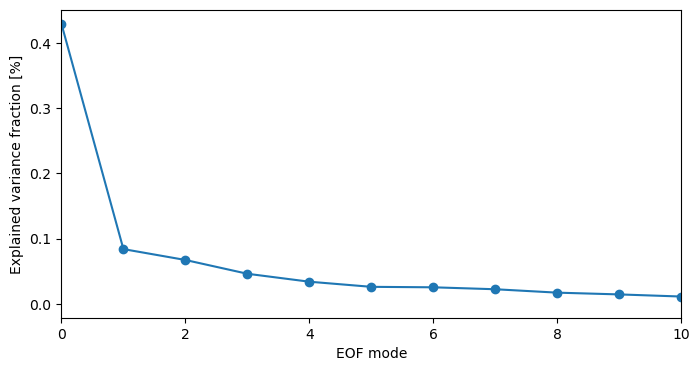

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
eof_solver.varianceFraction().plot(marker='o', ax=ax)
ax.set_ylabel('Explained variance fraction [%]')
ax.set_xlabel('EOF mode')
ax.set_xlim(0, 10)
plt.savefig('figs/sea_ice_variability/SIT_EOF_variance_fraction.png', bbox_inches='tight')
plt.show()

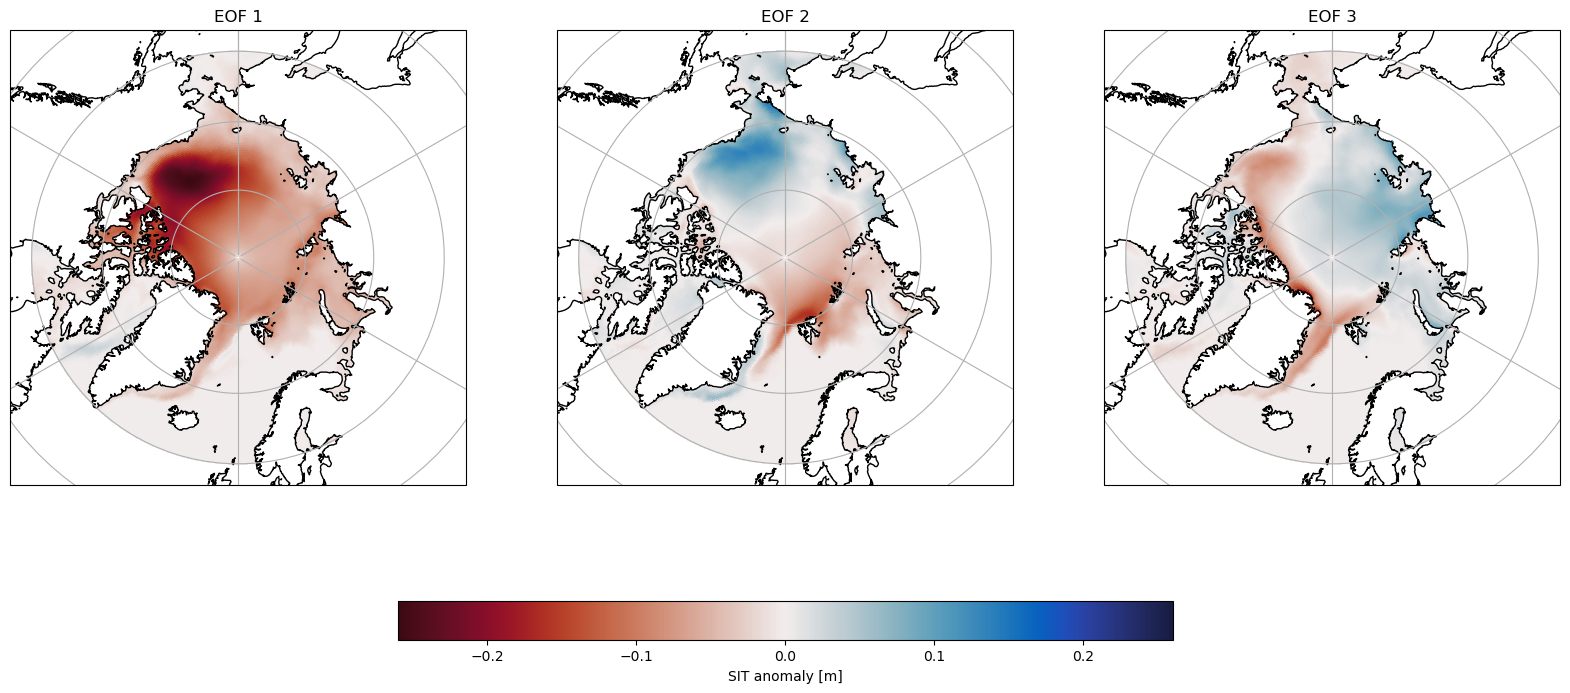

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})

max_val = np.abs(eof_solver.eofs(eofscaling=2)[:3]).max()

for i in range(3):
    ax = axs[i]
    ax.coastlines()
    ax.gridlines()
    pcm = ax.pcolormesh(
        ds_anomalies.longitude, 
        ds_anomalies.latitude, 
        eof_solver.eofs(eofscaling=2)[i], 
        transform=ccrs.PlateCarree(), 
        cmap=cmo.balance.reversed(),
        norm=colors.Normalize(vmin=-max_val, vmax=max_val),
    )
    ax.set_title(f'EOF {i+1}')
plt.colorbar(pcm, ax=axs, label='SIT anomaly [m]', orientation='horizontal', shrink=0.5)
plt.savefig('figs/sea_ice_variability/SIT_EOFs.png', bbox_inches='tight')
plt.show()

Les EOFs expliquent bien la variabilité visualisée sur la carte de std

L'EOF 1 correspond à une fonte globale de la banquise, on s'attend à ce que la PC associée soit croissante du temps.

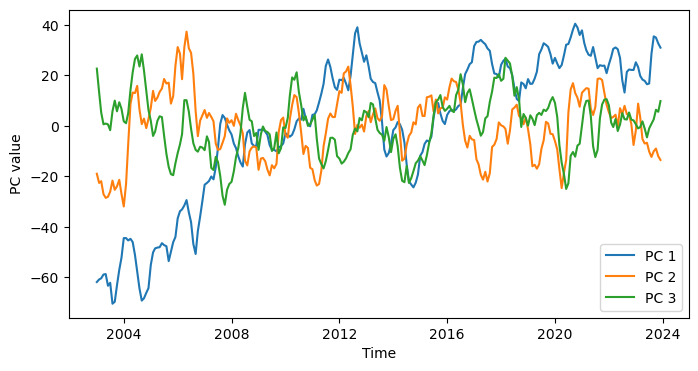

In [30]:
from scipy.fft import fft, fftfreq

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i in range(3):
    ax.plot(ds_anomalies.time, eof_solver.pcs()[:, i], label=f'PC {i+1}')
ax.set_ylabel('PC value')
ax.set_xlabel('Time')
ax.legend()
plt.savefig('figs/sea_ice_variability/SIT_PCs.png', bbox_inches='tight')
plt.show()


Effectivement, le mode 1 augmente bien au cours du temps : signature du réchauffement climatique

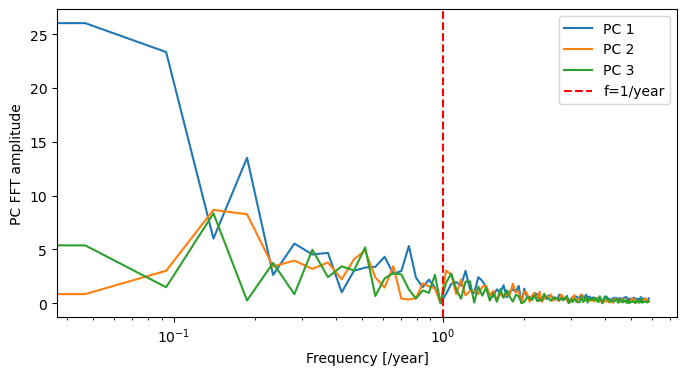

In [31]:

# Number of sample points
N = len(ds_anomalies.time)
# Sample spacing
T = (ds_anomalies.time[1] - ds_anomalies.time[0]).values.astype('timedelta64[D]').astype(int) / 365.25

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i in range(3):
    yf = fft(eof_solver.pcs()[:, i].values)
    xf = fftfreq(N, T)[:N//2]
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'PC {i+1}')

ax.axvline(x=1, color='r', linestyle='--', label='f=1/year')
plt.legend()
plt.xlabel('Frequency [/year]')
plt.ylabel('PC FFT amplitude')
plt.xscale('log')
plt.savefig('figs/sea_ice_variability/SIT_PCs_FFT.png', bbox_inches='tight')
plt.show()

surtout de la variabilité interannuelle (peu de variabilité intraannuelle)

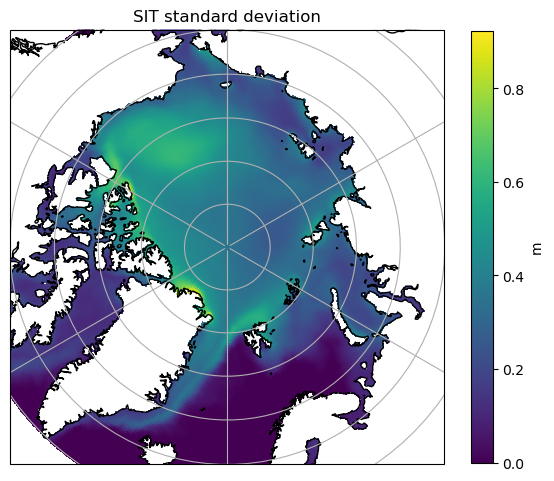

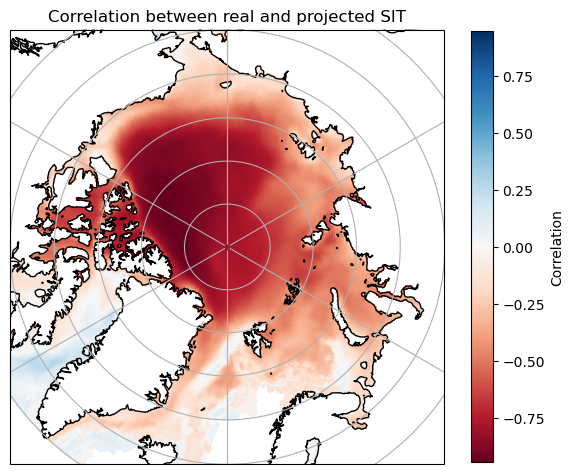

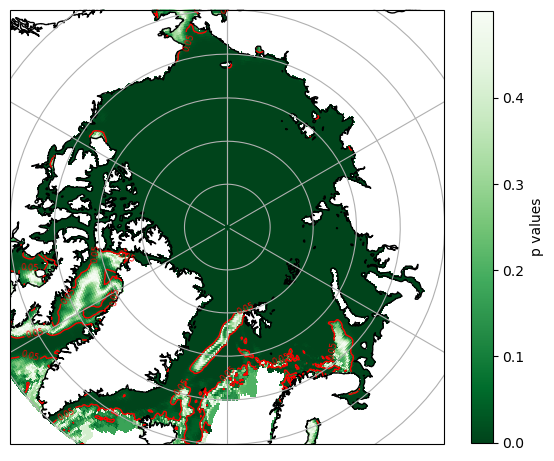

In [47]:
import scipy.stats

SIT_std = ds_anomalies['SIT'].std('time')

real_SIT = ds_anomalies['SIT'] # (time, latitude, longitude)
PC1 = eof_solver.pcs()[:, 0] # (time)
corr = (real_SIT * PC1).sum('time') / (real_SIT.std('time') * PC1.std('time')) / len(real_SIT.time)

t_test = corr * np.sqrt(len(real_SIT.time) - 2) / np.sqrt(1 - corr**2)

# Compute p-values from t-test
p_values = 1 - scipy.stats.t.cdf(np.abs(t_test), df=len(real_SIT.time) - 2)

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    real_SIT.std('time'), 
    transform=ccrs.PlateCarree(), 
    cmap='viridis'
)
ax.set_title(f'SIT standard deviation')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='m')


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    corr, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin=-max_val,
    vmax=max_val,
)
ax.set_title(f'Correlation between real and projected SIT')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Correlation')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    cmap='Greens_r',
    #norm=colors.LogNorm(),
)
cntr = ax.contour(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    levels=[0.05],
    colors='red',
    linewidths=1
)
ax.clabel(cntr, inline=True, fontsize=6, fmt='%1.2f')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='p values')

plt.savefig('figs/sea_ice_variability/SIT_PCA_t_test.png', bbox_inches='tight')
plt.show()
